In [1]:
import pandas as pd

# Load the dataset
data_path = 'Port_Data.csv'
data = pd.read_csv(data_path)

# Display the first few rows of the dataset to understand its structure
data.head()

,Unnamed: 0,Country,Port Name,UN Code,Vessels in Port,Departures(Last 24 Hours),Arrivals(Last 24 Hours),Expected Arrivals,Type,Area Local,Area Global,Also known as
0,0,China,SHANGHAI,CNSHG,2420,1376,1626,644,Port,East China Sea,Central China,"['SHANG HAI', ' YANGSHAN', ' CNSHA', ' CNSGH']"
1,1,China,NANTONG,CNNTG,1572,1173,1287,234,Port,East China Sea,Central China,['NAN TONG']
2,2,China,CJK,CNCJK,1529,343,370,310,Anchorage,East China Sea,Central China,"['CHANGJIANGKOU', ' CHANGJIANG KOU', ' CJK CN']"
3,3,China,NANJING,CNNKG,1414,667,1060,203,Port,East China Sea,Central China,"['NAN JING', ' NAN JIN', ' NANJIN']"
4,4,China,JIANGYIN,CNJIA,1112,1076,1070,166,Port,East China Sea,Central China,"['-', ' JANG JIN', ' JIANG YIN']"


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Unnamed: 0                 480 non-null    int64 
 1   Country                    480 non-null    object
 2   Port Name                  480 non-null    object
 3   UN Code                    468 non-null    object
 4   Vessels in Port            480 non-null    int64 
 5   Departures(Last 24 Hours)  480 non-null    int64 
 6   Arrivals(Last 24 Hours)    480 non-null    int64 
 7   Expected Arrivals          480 non-null    int64 
 8   Type                       480 non-null    object
 9   Area Local                 480 non-null    object
 10  Area Global                480 non-null    object
 11  Also known as              480 non-null    object
dtypes: int64(5), object(7)
memory usage: 45.1+ KB


In [3]:
data.describe()

,Unnamed: 0,Vessels in Port,Departures(Last 24 Hours),Arrivals(Last 24 Hours),Expected Arrivals
count,480.000000,480.000000,480.000000,480.000000,480.000000
mean,239.500000,153.312500,98.981250,108.662500,39.233333
std,138.708327,217.297037,170.504574,185.357564,82.385289
min,0.000000,51.000000,0.000000,1.000000,0.000000
25%,119.750000,63.000000,26.750000,30.000000,3.000000
50%,239.500000,86.000000,48.000000,56.000000,16.000000
75%,359.250000,144.000000,102.000000,106.250000,40.250000
max,479.000000,2420.000000,1682.000000,1748.000000,1205.000000


In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Selecting relevant features for prediction
features = data[['Vessels in Port', 'Departures(Last 24 Hours)', 'Arrivals(Last 24 Hours)']]
target = data['Expected Arrivals']

# Normalizing the features
scaler = MinMaxScaler()
features_normalized = scaler.fit_transform(features)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_normalized, target, test_size=0.2, random_state=42)

# Reshaping input to be [samples, time steps, features] which is required for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

X_train.shape, X_test.shape

((384, 1, 3), (96, 1, 3))

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Defining the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(1, 3)),  # LSTM layer with 50 units
    Dense(1)  # Output layer
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # Using Mean Squared Error and Mean Absolute Error

# Early stopping to halt training when validation loss isn't decreasing
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



In [6]:
# Training the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    validation_split=0.2,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=0
)

In [7]:
# Evaluating the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

Test Loss: 7865.93603515625, Test MAE: 41.912784576416016


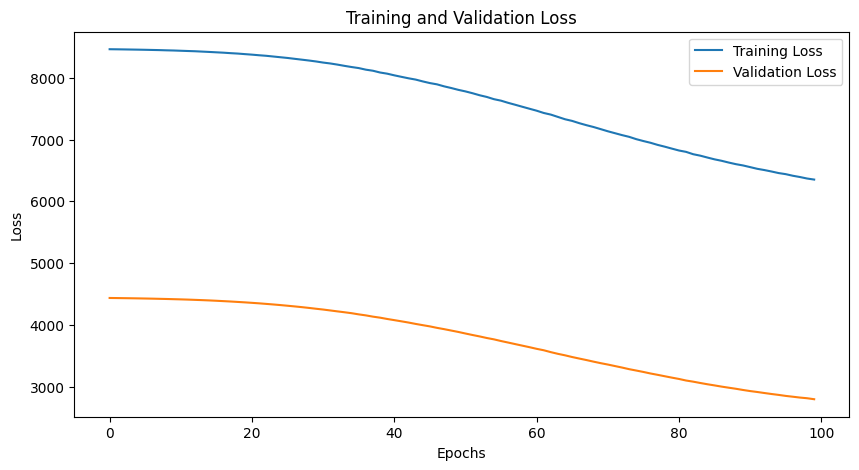

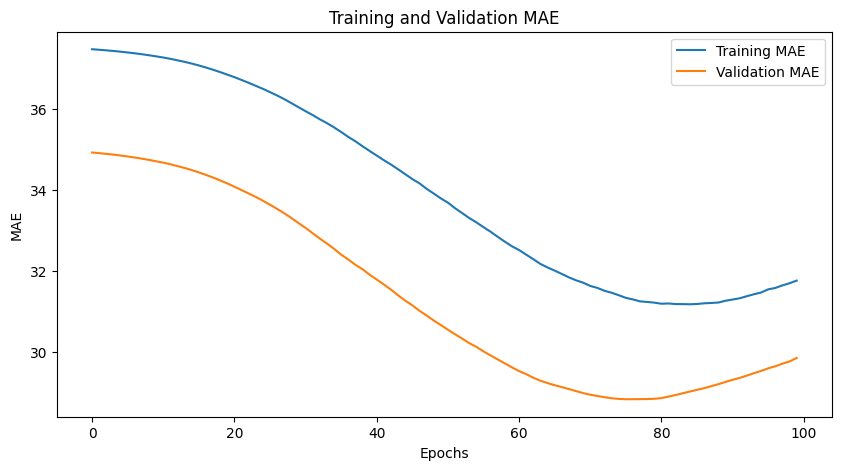

In [8]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation MAE
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [9]:
model.save('eta_prediction_model.h5')  # Saves the model

c:\Users\kimch\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
from tensorflow.keras.models import load_model

# Load the previously saved model
model = load_model('eta_prediction_model.h5')

In [11]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Example real-time data
real_time_data = np.array([[2420, 1376, 1626]])  # Example: ['Vessels in Port', 'Departures(Last 24 Hours)', 'Arrivals(Last 24 Hours)']

# Assuming scaler is loaded or initialized with the same parameters as during training
real_time_data_normalized = scaler.transform(real_time_data)

# Reshaping input to be [samples, time steps, features]
real_time_data_reshaped = np.reshape(real_time_data_normalized, (1, 1, 3))

c:\Users\kimch\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [12]:
predicted_eta = model.predict(real_time_data_reshaped)
print(f"Predicted ETA: {predicted_eta[0][0]}")

1/1 [==============================] - 0s 216ms/step
Predicted ETA: 101.02566528320312
